In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import re
import sys
sys.path.append('/home/midzay/Mlerning/bigartm/python')
import artm
import warnings
warnings.filterwarnings('ignore')


from ast import literal_eval
from tqdm import tqdm
from datetime import datetime as time


In [4]:
PATH = 'data/all/'

In [5]:
files = list(os.walk(PATH))[0][2]

In [6]:
file=files[0]
df = pd.read_csv(PATH+file)
#df = df[df.text!='text']
print(df.shape)
df.head(2)

(50856, 6)


,date,topic,text,predict,text_new,lemmatized_text
0,1999-10-01 12:00:00,Россия,"1 октября в Москве в отеле ""Аэростар"" открылас...",Интернет и СМИ,октября в москве в отеле аэростар открылась пе...,"['москва', 'отель', 'аэростарый', 'открыться',..."
1,1999-10-01 12:00:00,Мир,"Украинский порнографический сайт занял домен, ...",Интернет и СМИ,украинский порнографический сайт занял домен р...,"['украинский', 'порнографический', 'сайт', 'за..."


In [7]:
df.lemmatized_text = df.lemmatized_text.apply(lambda x: literal_eval(x))

* get dates

In [8]:
df['year'] = df['date'].apply(lambda x: int(x.split(' ')[0].split('-')[0]))
df['month'] = df['date'].apply(lambda x: int(x.split(' ')[0].split('-')[1]))
df.head(2)

,date,topic,text,predict,text_new,lemmatized_text,year,month
0,1999-10-01 12:00:00,Россия,"1 октября в Москве в отеле ""Аэростар"" открылас...",Интернет и СМИ,октября в москве в отеле аэростар открылась пе...,"[москва, отель, аэростарый, открыться, московс...",1999,10
1,1999-10-01 12:00:00,Мир,"Украинский порнографический сайт занял домен, ...",Интернет и СМИ,украинский порнографический сайт занял домен р...,"[украинский, порнографический, сайт, занять, д...",1999,10


In [9]:
df = df[df.year>2007]
df.head(2)

,date,topic,text,predict,text_new,lemmatized_text,year,month
8928,2008-01-01 12:00:00,Интернет и СМИ,C 1 января 2008 года на территории Азербайджан...,Интернет и СМИ,c января года на территории азербайджана пре...,"[территория, азербайджан, прекратить, вещание,...",2008,1
8929,2008-01-01 12:00:00,Из жизни,Специалисты по связям с общественностью америк...,Интернет и СМИ,специалисты по связям с общественностью америк...,"[специалист, связь, общественность, американск...",2008,1


* add docID

In [10]:
df['docID'] = list(range(df.shape[0]))
df = df[['docID','year','month','lemmatized_text']]
df.head(2)

,docID,year,month,lemmatized_text
8928,0,2008,1,"[территория, азербайджан, прекратить, вещание,..."
8929,1,2008,1,"[специалист, связь, общественность, американск..."


In [11]:
print(df.shape)
df.isnull().sum()

(41928, 4)


docID              0
year               0
month              0
lemmatized_text    0
dtype: int64

* look at unique dates

In [12]:
df_data = df[['year','month']]
print(df_data.shape)
df_data.head(2)

(41928, 2)


,year,month
8928,2008,1
8929,2008,1


In [13]:
select_topics = 15

In [14]:
vwpath= f'data/vwpath/{file}_input_bigartm.vw'

with open(vwpath, 'w') as fp:
    for text, did in df[['lemmatized_text', 'docID']].values:
        fp.write('{} | {}\n'.format(did, ' '.join(text)))

In [15]:
id_date = df[['docID', 'year', 'month']].copy()

In [16]:
batches_path = f'data/batches/{file}'

if not os.path.exists(batches_path):
    print('create folder...\n')
    os.makedirs(batches_path)
    
batch_vectorizer = artm.BatchVectorizer(data_path=vwpath,
                                              data_format='vowpal_wabbit',
                                              target_folder=batches_path)

print(batch_vectorizer)

create folder...

artm.BatchVectorizer(data_path="data/batches/Internet_i_SMI.csv.bz2", num_batches=42)


In [17]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=batches_path)
dictionary.filter(min_tf=10, max_df_rate=0.1) #int(4.5e5)

artm.Dictionary(name=e7e49d01-b2fb-47b8-8538-5a3c7a60fcef, num_entries=23969)

In [18]:
%%time
model = artm.ARTM(num_topics=select_topics, dictionary=dictionary, show_progress_bars=True)

# scores
model.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))

# 1st regularizer
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1.0)) #-0.1
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)

# 2st regularizer
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5))
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

# 3st regularizer
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5))

model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

print(f"\tSparsityThetaScore: {model.score_tracker['SparsityThetaScore'].last_value}")
print(f"\tSparsityPhiScore: {model.score_tracker['SparsityPhiScore'].last_value}")
print(f"\tPerplexityScore: {model.score_tracker['PerplexityScore'].last_value}")


	SparsityThetaScore: 0.5631956458091736
	SparsityPhiScore: 0.8461095690727234
	PerplexityScore: 646.8890380859375
CPU times: user 9min 8s, sys: 3.08 s, total: 9min 11s
Wall time: 2min 47s


* print top words for each topics

In [19]:
phi = model.get_phi()
phi['word'] = phi.index
phi['word']=phi.word.apply(lambda x: x[1])

for col in phi.columns:
    if col != 'word':
        print(f"{col}: {phi[[col, 'word']].sort_values(by=col, ascending=False)['word'].values[:10]}")

topic_0: ['google' 'приложение' 'яндекс' 'мобильный' 'устройство' 'apple' 'запрос'
 'поисковый' 'microsoft' 'поисковик']
topic_1: ['холдинг' 'иск' 'эхо' 'радиостанция' 'редактор' 'гендиректор' 'акция'
 'генеральный' 'должность' 'медиа']
topic_2: ['британский' 'news' 'великобритания' 'бибись' 'bbc' 'daily' 'житель'
 'ребёнок' 'лондон' 'корпорация']
topic_3: ['реклама' 'миллиард' 'доллар' 'рынок' 'рубль' 'составить' 'рекламный'
 'доля' 'продажа' 'аудитория']
topic_4: ['роскомнадзор' 'запретить' 'блокировка' 'ведомство' 'требование'
 'telegram' 'законопроект' 'нарушение' 'госдума' 'реестр']
topic_5: ['украина' 'украинский' 'корреспондент' 'задержать' 'убийство' 'произойти'
 'журналистка' 'нападение' 'акция' 'здание']
topic_6: ['ролик' 'фильм' 'реклама' 'youtube' 'видео' 'рекламный' 'игра' 'сериал'
 'просмотр' 'шоу']
topic_7: ['атака' 'хакер' 'безопасность' 'взлом' 'хакерский' 'документ' 'wikileaks'
 'спецслужба' 'против' 'взломать']
topic_8: ['оператор' 'дождь' 'правительство' 'совет' 'ра

In [20]:
theta = model.transform(batch_vectorizer=batch_vectorizer)
theta = theta.T

theta.head(2)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
2000,0.000000,0.546480,0.0,0.274183,0.0,0.0,0.000000,0.000000,0.066795,0.0,0.048189,0.011433,0.047104,0.000000,0.005817
2001,0.315377,0.111206,0.0,0.121470,0.0,0.0,0.341315,0.021402,0.000000,0.0,0.015188,0.022272,0.000000,0.051771,0.000000


In [21]:
joined = id_date.join(theta)
joined.head(2)

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
8928,0,2008,1,0.023799,0.066611,0.0,0.000000,0.0,0.0,0.0,0.0,0.016855,0.0,0.0,0.824491,0.000000,0.049214,0.01903
8929,1,2008,1,0.023947,0.515531,0.0,0.098493,0.0,0.0,0.0,0.0,0.009475,0.0,0.0,0.000000,0.174806,0.177748,0.00000


In [22]:
joined.tail()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
50851,41923,2019,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50852,41924,2019,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50853,41925,2019,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50854,41926,2019,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50855,41927,2019,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
topics = ['topic_{}'.format(i) for i in range(select_topics)]
gb = joined.groupby(['year', 'month'])[topics].sum()

print(f'gb.shape: {gb.shape}')
gb.head()

gb.shape: (133, 15)


topic_0    topic_1    topic_2    topic_3    topic_4    topic_5  \
year month                                                                     
2008 1      11.465693  10.408325   6.653252  11.778435   4.929718   3.385396   
     2      15.371150   7.307426   7.020677  14.656156  11.127521   7.749699   
     3      22.028456  23.449619  10.008844  22.564577  26.662798  11.715660   
     4      21.690577  14.832255  13.430907  25.626894  23.059141  16.508060   
     5      11.100416  15.348485  10.381469  14.029121  19.239885   9.715383   

              topic_6    topic_7    topic_8    topic_9   topic_10   topic_11  \
year month                                                                     
2008 1      11.191312   9.200893   4.274529   6.340583   6.458014   8.921255   
     2      14.513623  13.017031   3.502111   9.660797   4.509651  17.616970   
     3      14.208645  22.847000  12.848881  15.096536  12.276622  21.910419   
     4      20.146084  30.529320  12.754807  16.473301  14.736393  18.227959   
     5      21.168571  12.615438   6.828261  13.180027   9.601432  12.516126   

             topic_12   topic_13   topic_14  
year month                                   
2008 1       7.298472   7.814586   3.879535  
     2       6.051896  10.698102   8.197190  
     3      15.928604  16.683352  15.769986  
     4      13.819279  14.921395  12.243626  
     5      13.811874  12.053000  10.410511

* joypy

In [24]:
import joypy # !pip install joypy

In [25]:
joined['date'] = ['{}-{:02d}-01'.format(a, b) for a, b in joined[['year', 'month']].values]
cols = [c for c in joined.columns if c.startswith('topic')]

joined.head()

,docID,year,month,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,date
8928,0,2008,1,0.023799,0.066611,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.016855,0.000000,0.000000,0.824491,0.000000,0.049214,0.019030,2008-01-01
8929,1,2008,1,0.023947,0.515531,0.000000,0.098493,0.000000,0.00000,0.000000,0.000000,0.009475,0.000000,0.000000,0.000000,0.174806,0.177748,0.000000,2008-01-01
8930,2,2008,1,0.000000,0.420802,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.024426,0.291188,0.029580,0.072185,0.161818,0.000000,2008-01-01
8931,3,2008,1,0.000000,0.000000,0.379019,0.051819,0.000000,0.16489,0.210629,0.000000,0.000000,0.112732,0.024091,0.001829,0.040268,0.014723,0.000000,2008-01-01
8932,4,2008,1,0.000000,0.058267,0.223079,0.000000,0.032235,0.00000,0.208453,0.055445,0.000000,0.237030,0.000000,0.000000,0.000000,0.085616,0.099875,2008-01-01


In [26]:
dd = joined[cols + ['date']].melt('date', var_name='topic', value_name='mentions')
dd = dd[dd['mentions'] > 0]

dd2 = dd.groupby(['date','topic']).sum()
dd2=dd2.reset_index()

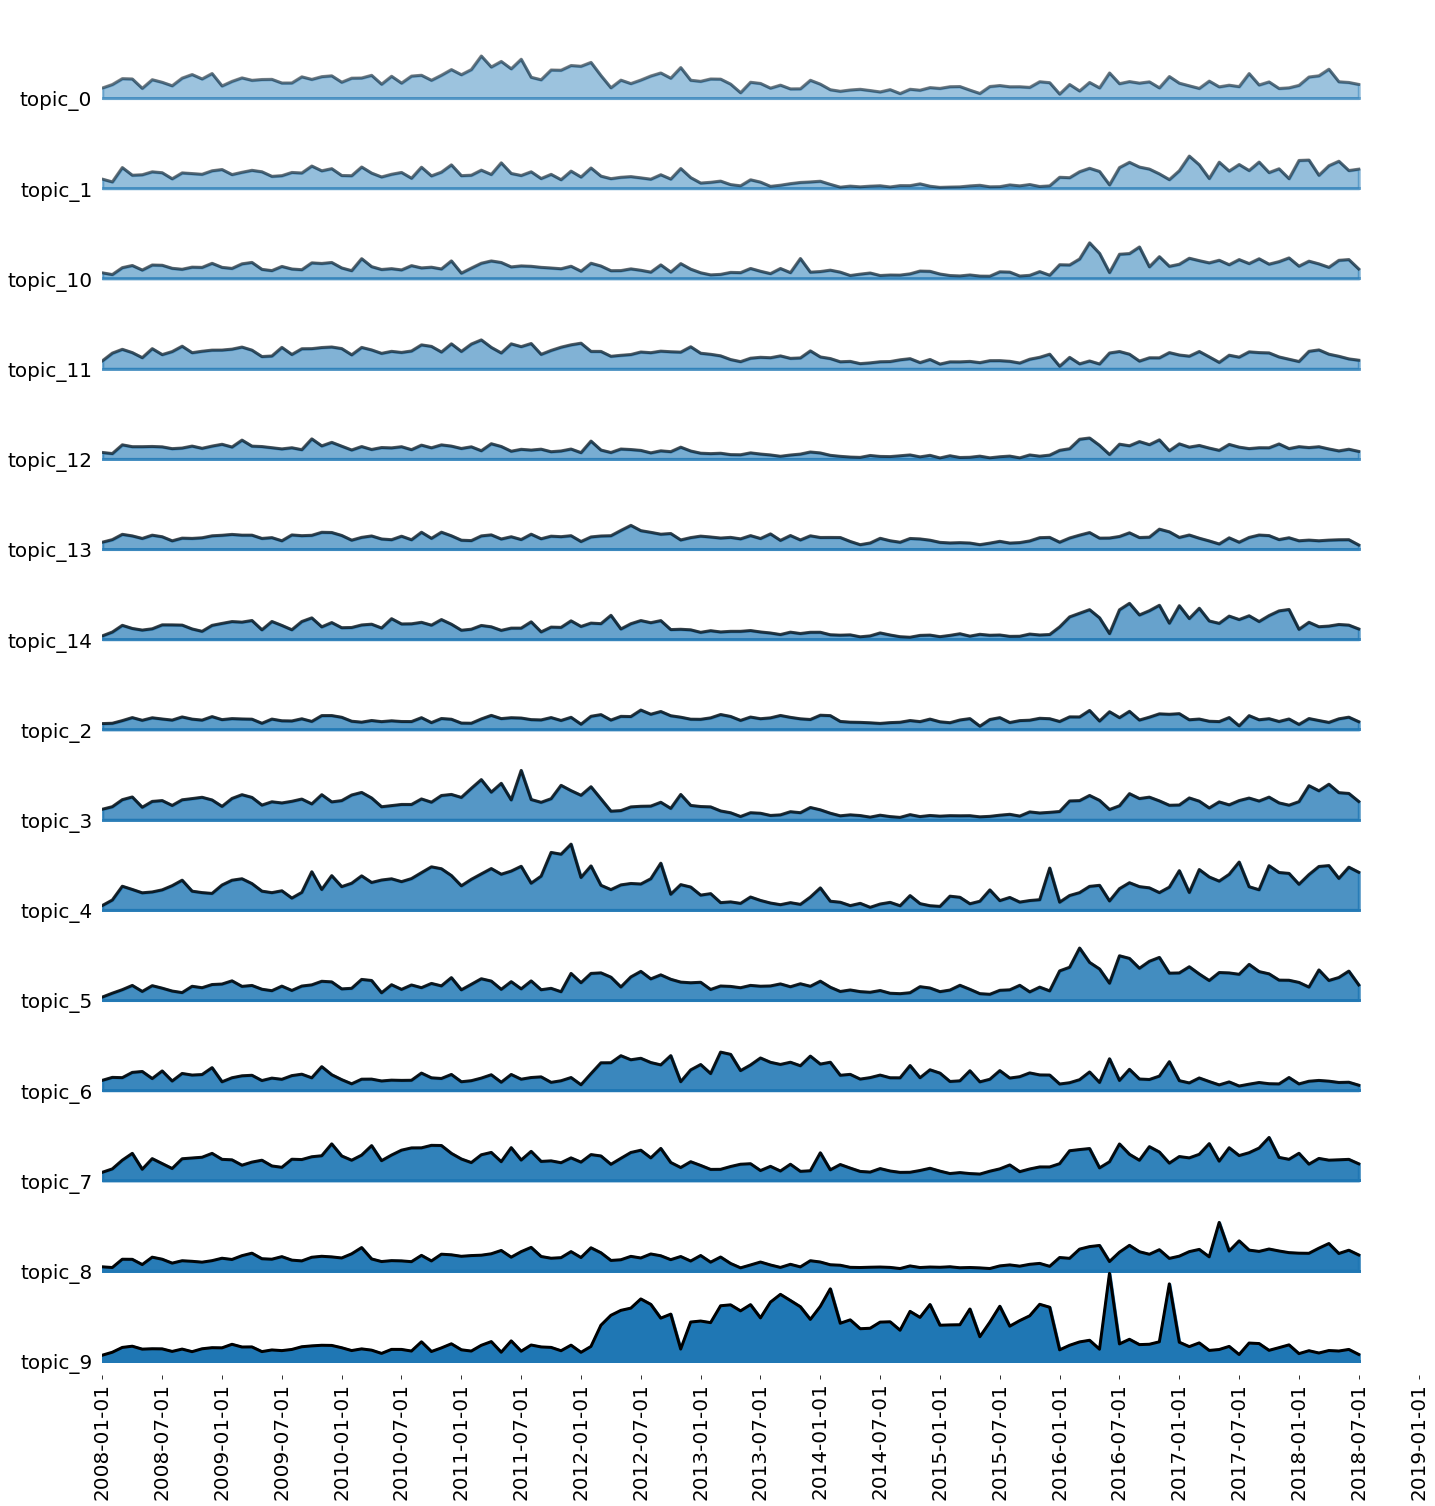

In [27]:
labels = sorted(joined['date'].unique())
fig_interfax, axes = joypy.joyplot(dd2, by='topic', column='mentions', figsize=(20, 20),
                          xlabelsize=20,ylabelsize=20,
                          overlap=0.4, fill=True,
                          linecolor="k",linewidth=3,
                          kind='values', fade=True, xrot=90,
                          x_range=[i for i in range(len(labels))],
                          background='white');

ticks_labels = {i:t for i, t in enumerate(labels)}
axes[-1].set_xticks([k for k, v in ticks_labels.items() if k % 6 == 0])
ticks = axes[-1].get_xticks()
axes[-1].set_xticklabels([ticks_labels.get(i, 'stop') for i in ticks]);

Интерфакс начинается с 2008 года. Поэтому такое затишье вначале

In [236]:
#fig_interfax.savefig(f"data/interfax/interfax_{'-'.join(name_dataset_interfax.split('.'))}_joypy")